

# Background on projectors and projections

This tutorial provides background information on projectors and Signal Space
Projection (SSP), and covers loading and saving projectors, adding and removing
projectors from Raw objects, the difference between "applied" and "unapplied"
projectors, and at what stages MNE-Python applies projectors automatically.

We'll start by importing the Python modules we need; we'll also define a short
function to make it easier to make several plots that look similar:


In [ ]:
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy.linalg import svd

import mne


def setup_3d_axes():
    ax = plt.axes(projection="3d")
    ax.view_init(azim=-105, elev=20)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_xlim(-1, 5)
    ax.set_ylim(-1, 5)
    ax.set_zlim(0, 5)
    return ax

## What is a projection?

In the most basic terms, a *projection* is an operation that converts one set
of points into another set of points, where repeating the projection
operation on the resulting points has no effect. To give a simple geometric
example, imagine the point $(3, 2, 5)$ in 3-dimensional space. A
projection of that point onto the $x, y$ plane looks a lot like a
shadow cast by that point if the sun were directly above it:



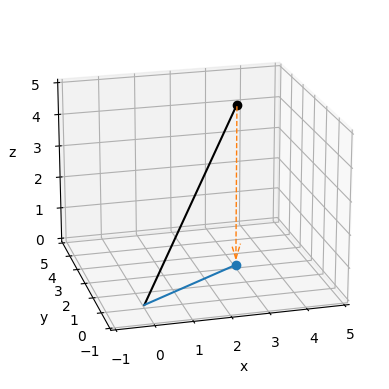

In [13]:
ax = setup_3d_axes()

# plot the vector (3, 2, 5)
origin = np.zeros((3, 1))
point = np.array([[3, 2, 5]]).T
vector = np.hstack([origin, point])
ax.plot(*vector, color="k")
ax.plot(*point, color="k", marker="o")

# project the vector onto the x,y plane and plot it
xy_projection_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
projected_point = xy_projection_matrix @ point
projected_vector = xy_projection_matrix @ vector
ax.plot(*projected_vector, color="C0")
ax.plot(*projected_point, color="C0", marker="o")

# add dashed arrow showing projection
arrow_coords = np.concatenate([point, projected_point - point]).flatten()
ax.quiver3D(
    *arrow_coords,
    length=0.96,
    arrow_length_ratio=0.1,
    color="C1",
    linewidth=1,
    linestyle="dashed",
)

<div class="alert alert-info"><h4>Note</h4><p>The ``@`` symbol indicates matrix multiplication on NumPy arrays, and was
    introduced in Python 3.5 / NumPy 1.10. The notation ``plot(*point)`` uses
    Python `argument expansion`_ to "unpack" the elements of ``point`` into
    separate positional arguments to the function. In other words,
    ``plot(*point)`` expands to ``plot(3, 2, 5)``.</p></div>

Notice that we used matrix multiplication to compute the projection of our
point $(3, 2, 5)$ onto the $x, y$ plane:

\begin{align}\left[
      \begin{matrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \end{matrix}
    \right]
    \left[ \begin{matrix} 3 \\ 2 \\ 5 \end{matrix} \right] =
    \left[ \begin{matrix} 3 \\ 2 \\ 0 \end{matrix} \right]\end{align}

...and that applying the projection again to the result just gives back the
result again:

\begin{align}\left[
      \begin{matrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 0 \end{matrix}
    \right]
    \left[ \begin{matrix} 3 \\ 2 \\ 0 \end{matrix} \right] =
    \left[ \begin{matrix} 3 \\ 2 \\ 0 \end{matrix} \right]\end{align}

From an information perspective, this projection has taken the point
$x, y, z$ and removed the information about how far in the $z$
direction our point was located; all we know now is its position in the
$x, y$ plane. Moreover, applying our projection matrix to *any point*
in $x, y, z$ space will reduce it to a corresponding point on the
$x, y$ plane. The term for this is a *subspace*: the projection matrix
projects points in the original space into a *subspace* of lower dimension
than the original. The reason our subspace is the $x,y$ plane (instead
of, say, the $y,z$ plane) is a direct result of the particular values
in our projection matrix.


### Example: projection as noise reduction

Another way to describe this "loss of information" or "projection into a
subspace" is to say that projection reduces the rank (or "degrees of
freedom") of the measurement — here, from 3 dimensions down to 2. On the
other hand, if you know that measurement component in the $z$ direction
is just noise due to your measurement method, and all you care about are the
$x$ and $y$ components, then projecting your 3-dimensional
measurement into the $x, y$ plane could be seen as a form of noise
reduction.

Of course, it would be very lucky indeed if all the measurement noise were
concentrated in the $z$ direction; you could just discard the $z$
component without bothering to construct a projection matrix or do the matrix
multiplication. Suppose instead that in order to take that measurement you
had to pull a trigger on a measurement device, and the act of pulling the
trigger causes the device to move a little. If you measure how
trigger-pulling affects measurement device position, you could then "correct"
your real measurements to "project out" the effect of the trigger pulling.
Here we'll suppose that the average effect of the trigger is to move the
measurement device by $(3, -1, 1)$:



In [4]:
trigger_effect = np.array([[3, -1, 1]]).T

Knowing that, we can compute a plane that is orthogonal to the effect of the
trigger (using the fact that a plane through the origin has equation
$Ax + By + Cz = 0$ given a normal vector $(A, B, C)$), and
project our real measurements onto that plane.



In [5]:
# compute the plane orthogonal to trigger_effect
x, y = np.meshgrid(np.linspace(-1, 5, 61), np.linspace(-1, 5, 61))
A, B, C = trigger_effect
z = (-A * x - B * y) / C
# cut off the plane below z=0 (just to make the plot nicer)
mask = np.where(z >= 0)
x = x[mask]
y = y[mask]
z = z[mask]

Computing the projection matrix from the ``trigger_effect`` vector is done
using [singular value decomposition](svd_) (SVD); interested readers may
consult the internet or a linear algebra textbook for details on this method.
With the projection matrix in place, we can project our original vector
$(3, 2, 5)$ to remove the effect of the trigger, and then plot it:



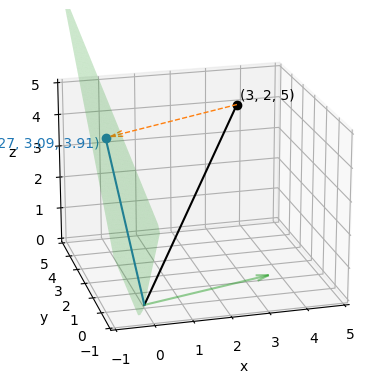

In [16]:
# compute the projection matrix
U, S, V = svd(trigger_effect, full_matrices=False)
trigger_projection_matrix = np.eye(3) - U @ U.T

# project the vector onto the orthogonal plane
projected_point = trigger_projection_matrix @ point
projected_vector = trigger_projection_matrix @ vector

# plot the trigger effect and its orthogonal plane
ax = setup_3d_axes()
ax.plot_trisurf(x, y, z, color="C2", shade=False, alpha=0.25)
ax.quiver3D(
    *np.concatenate([origin, trigger_effect]).flatten(),
    arrow_length_ratio=0.1,
    color="C2",
    alpha=0.5,
)
# plot the original vector
ax.plot(*vector, color="k")
ax.plot(*point, color="k", marker="o")
offset = np.full((3, 1), 0.1)
ax.text(*(point + offset).flat, "({}, {}, {})".format(*point.flat), color="k")

# plot the projected vector
ax.plot(*projected_vector, color="C0")
ax.plot(*projected_point, color="C0", marker="o")
offset = np.full((3, 1), -0.2)
ax.text(
    *(projected_point + offset).flat,
    "({}, {}, {})".format(*np.round(projected_point.flat, 2)),
    color="C0",
    horizontalalignment="right",
)

# add dashed arrow showing projection
arrow_coords = np.concatenate([point, projected_point - point]).flatten()
ax.quiver3D(
    *arrow_coords,
    length=0.96,
    arrow_length_ratio=0.1,
    color="C1",
    linewidth=1,
    linestyle="dashed",
)


Just as before, the projection matrix will map *any point* in $x, y, z$
space onto that plane, and once a point has been projected onto that plane,
applying the projection again will have no effect. For that reason, it should
be clear that although the projected points vary in all three $x$,
$y$, and $z$ directions, the set of projected points have only
two *effective* dimensions (i.e., they are constrained to a plane).

.. admonition:: Terminology
    :class: sidebar note

    In MNE-Python, the matrix used to project a raw signal into a subspace is
    usually called a :term:`projector` or a *projection
    operator* — these terms are interchangeable with the term *projection
    matrix* used above.

Projections of EEG or MEG signals work in very much the same way: the point
$x, y, z$ corresponds to the value of each sensor at a single time
point, and the projection matrix varies depending on what aspects of the
signal (i.e., what kind of noise) you are trying to project out. The only
real difference is that instead of a single 3-dimensional point $(x, y,
z)$ you're dealing with a time series of $N$-dimensional "points" (one
at each sampling time), where $N$ is usually in the tens or hundreds
(depending on how many sensors your EEG/MEG system has). Fortunately, because
projection is a matrix operation, it can be done very quickly even on signals
with hundreds of dimensions and tens of thousands of time points.



## Signal-space projection (SSP)

We mentioned above that the projection matrix will vary depending on what
kind of noise you are trying to project away. Signal-space projection (SSP)
:footcite:`UusitaloIlmoniemi1997` is a way of estimating what that projection
matrix should be, by
comparing measurements with and without the signal of interest. For example,
you can take additional "empty room" measurements that record activity at the
sensors when no subject is present. By looking at the spatial pattern of
activity across MEG sensors in an empty room measurement, you can create one
or more $N$-dimensional vector(s) giving the "direction(s)" of
environmental noise in sensor space (analogous to the vector for "effect of
the trigger" in our example above). SSP is also often used for removing
heartbeat and eye movement artifacts — in those cases, instead of empty room
recordings the direction of the noise is estimated by detecting the
artifacts, extracting epochs around them, and averaging. See
`tut-artifact-ssp` for examples.

Once you know the noise vectors, you can create a hyperplane that is
orthogonal
to them, and construct a projection matrix to project your experimental
recordings onto that hyperplane. In that way, the component of your
measurements associated with environmental noise can be removed. Again, it
should be clear that the projection reduces the dimensionality of your data —
you'll still have the same number of sensor signals, but they won't all be
*linearly independent* — but typically there are tens or hundreds of sensors
and the noise subspace that you are eliminating has only 3-5 dimensions, so
the loss of degrees of freedom is usually not problematic.


## Projectors in MNE-Python

In our example data, `SSP <ssp-tutorial>` has already been performed
using empty room recordings, but the :term:`projectors <projector>` are
stored alongside the raw data and have not been *applied* yet (or,
synonymously, the projectors are not *active* yet). Here we'll load
the `sample data <sample-dataset>` and crop it to 60 seconds; you can
see the projectors in the output of :func:`~mne.io.read_raw_fif` below:



In [7]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(tmax=60).load_data()

Opening raw data file C:\Users\ABC\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


In MNE-Python, the environmental noise vectors are computed using [principal
component analysis](pca_), usually abbreviated "PCA", which is why the SSP
projectors usually have names like "PCA-v1". (Incidentally, since the process
of performing PCA uses [singular value decomposition](svd_) under the hood,
it is also common to see phrases like "projectors were computed using SVD" in
published papers.) The projectors are stored in the ``projs`` field of
``raw.info``:



In [8]:
print(raw.info["projs"])

[<Projection | PCA-v1, active : False, n_channels : 102>, <Projection | PCA-v2, active : False, n_channels : 102>, <Projection | PCA-v3, active : False, n_channels : 102>]


``raw.info['projs']`` is an ordinary Python :class:`list` of
:class:`~mne.Projection` objects, so you can access individual projectors by
indexing into it. The :class:`~mne.Projection` object itself is similar to a
Python :class:`dict`, so you can use its ``.keys()`` method to see what
fields it contains (normally you don't need to access its properties
directly, but you can if necessary):



In [9]:
first_projector = raw.info["projs"][0]
print(first_projector)
print(first_projector.keys())

<Projection | PCA-v1, active : False, n_channels : 102>
dict_keys(['desc', 'kind', 'active', 'data', 'explained_var'])


The :class:`~mne.io.Raw`, :class:`~mne.Epochs`, and :class:`~mne.Evoked`
objects all have a boolean :attr:`~mne.io.Raw.proj` attribute that indicates
whether there are any unapplied / inactive projectors stored in the object.
In other words, the :attr:`~mne.io.Raw.proj` attribute is ``True`` if at
least one :term:`projector` is present and all of them are active. In
addition, each individual projector also has a boolean ``active`` field:



In [10]:
print(raw.proj)
print(first_projector["active"])

False
False


### Computing projectors

In MNE-Python, SSP vectors can be computed using general purpose functions
:func:`mne.compute_proj_raw`, :func:`mne.compute_proj_epochs`, and
:func:`mne.compute_proj_evoked`. The general assumption these functions make
is that the data passed contains raw data, epochs or averages of the artifact
you want to repair via projection. In practice this typically involves
continuous raw data of empty room recordings or averaged ECG or EOG
artifacts. A second set of high-level convenience functions is provided to
compute projection vectors for typical use cases. This includes
:func:`mne.preprocessing.compute_proj_ecg` and
:func:`mne.preprocessing.compute_proj_eog` for computing the ECG and EOG
related artifact components, respectively; see `tut-artifact-ssp` for
examples of these uses. For computing the EEG reference signal as a
projector, the function :func:`mne.set_eeg_reference` can be used; see
`tut-set-eeg-ref` for more information.

<div class="alert alert-danger"><h4>Warning</h4><p>It is best to compute projectors only on channels that will be
             used (e.g., excluding bad channels). This ensures that
             projection vectors will remain ortho-normalized and that they
             properly capture the activity of interest.</p></div>


### Visualizing the effect of projectors

You can see the effect the projectors are having on the measured signal by
comparing plots with and without the projectors applied. By default,
``raw.plot()`` will apply the projectors in the background before plotting
(without modifying the :class:`~mne.io.Raw` object); you can control this
with the boolean ``proj`` parameter as shown below, or you can turn them on
and off interactively with the projectors interface, accessed via the
:kbd:`Proj` button in the lower right corner of the plot window. Here we'll
look at just the magnetometers, and a 2-second sample from the beginning of
the file.



Removing projector <Projection | ECG-planar-999--0.200-0.400-PCA-01, active : False, n_channels : 203>
Removing projector <Projection | ECG-planar-999--0.200-0.400-PCA-02, active : False, n_channels : 203>
Removing projector <Projection | ECG-eeg-999--0.200-0.400-PCA-01, active : False, n_channels : 59>
Removing projector <Projection | ECG-eeg-999--0.200-0.400-PCA-02, active : False, n_channels : 59>


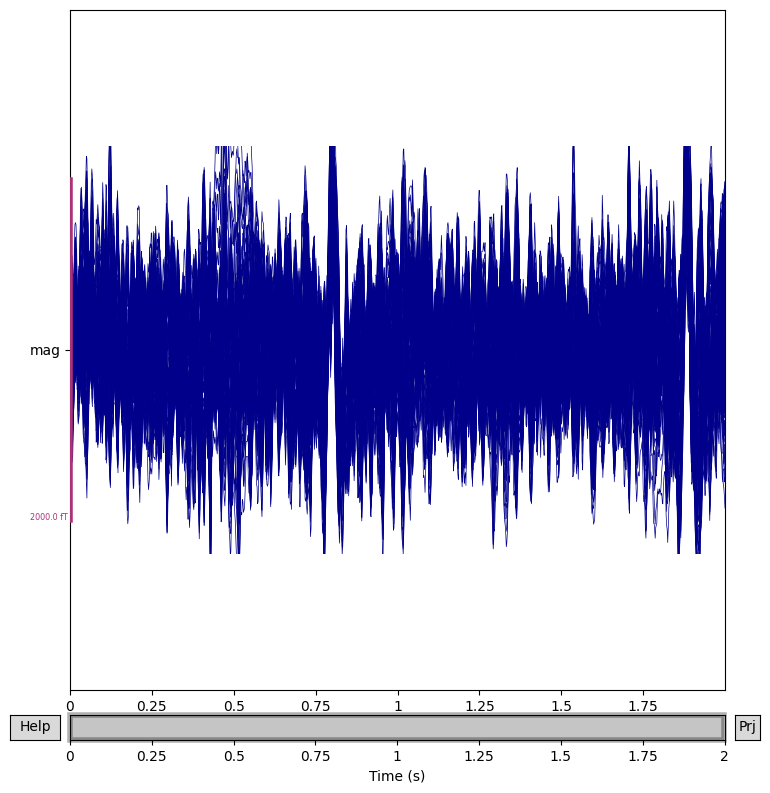

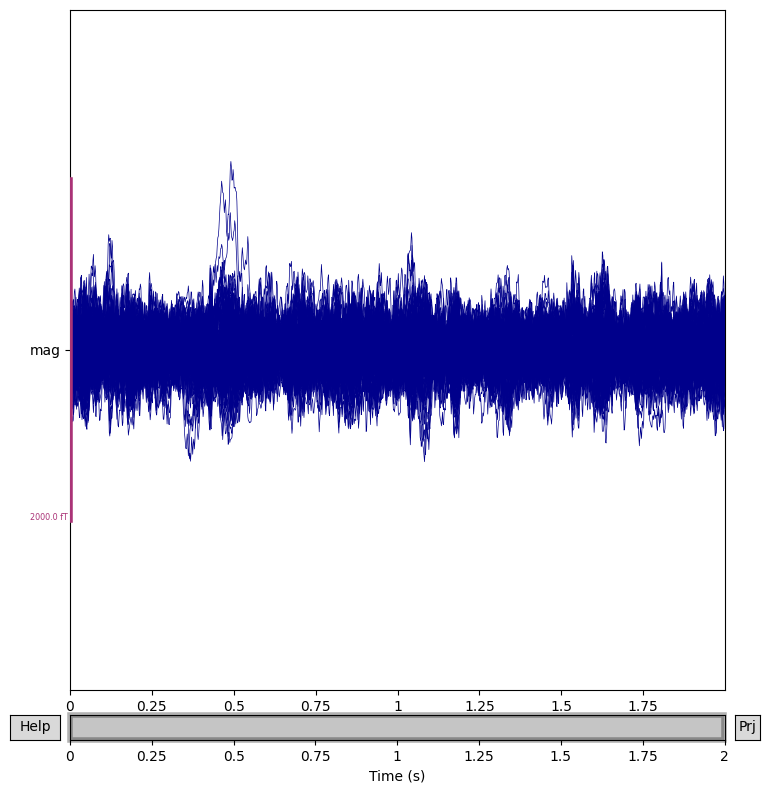

In [32]:
mags = raw.copy().crop(tmax=2).pick(picks="mag")
for proj in (False, True):
    with mne.viz.use_browser_backend("matplotlib"):
        fig = mags.plot(butterfly=True, proj=proj)
    fig.subplots_adjust(top=0.9)
    fig.suptitle("proj={}".format(proj), size="xx-large", weight="bold")

Additional ways of visualizing projectors are covered in the tutorial
`tut-artifact-ssp`.


### Loading and saving projectors

SSP can be used for other types of signal cleaning besides just reduction of
environmental noise. You probably noticed two large deflections in the
magnetometer signals in the previous plot that were not removed by the
empty-room projectors — those are artifacts of the subject's heartbeat. SSP
can be used to remove those artifacts as well. The sample data includes
projectors for heartbeat noise reduction that were saved in a separate file
from the raw data, which can be loaded with the :func:`mne.read_proj`
function:



In [33]:
ecg_proj_file = os.path.join(
    sample_data_folder, "MEG", "sample", "sample_audvis_ecg-proj.fif"
)
ecg_projs = mne.read_proj(ecg_proj_file)
print(ecg_projs)

    Read a total of 6 projection items:
        ECG-planar-999--0.200-0.400-PCA-01 (1 x 203)  idle
        ECG-planar-999--0.200-0.400-PCA-02 (1 x 203)  idle
        ECG-axial-999--0.200-0.400-PCA-01 (1 x 102)  idle
        ECG-axial-999--0.200-0.400-PCA-02 (1 x 102)  idle
        ECG-eeg-999--0.200-0.400-PCA-01 (1 x 59)  idle
        ECG-eeg-999--0.200-0.400-PCA-02 (1 x 59)  idle
[<Projection | ECG-planar-999--0.200-0.400-PCA-01, active : False, n_channels : 203>, <Projection | ECG-planar-999--0.200-0.400-PCA-02, active : False, n_channels : 203>, <Projection | ECG-axial-999--0.200-0.400-PCA-01, active : False, n_channels : 102>, <Projection | ECG-axial-999--0.200-0.400-PCA-02, active : False, n_channels : 102>, <Projection | ECG-eeg-999--0.200-0.400-PCA-01, active : False, n_channels : 59>, <Projection | ECG-eeg-999--0.200-0.400-PCA-02, active : False, n_channels : 59>]


There is a corresponding :func:`mne.write_proj` function that can be used to
save projectors to disk in ``.fif`` format:

```python3
mne.write_proj('heartbeat-proj.fif', ecg_projs)
```
<div class="alert alert-info"><h4>Note</h4><p>By convention, MNE-Python expects projectors to be saved with a filename
    ending in ``-proj.fif`` (or ``-proj.fif.gz``), and will issue a warning
    if you forgo this recommendation.</p></div>


### Adding and removing projectors

Above, when we printed the ``ecg_projs`` list that we loaded from a file, it
showed two projectors for gradiometers (the first two, marked "planar"), two
for magnetometers (the middle two, marked "axial"), and two for EEG sensors
(the last two, marked "eeg"). We can add them to the :class:`~mne.io.Raw`
object using the :meth:`~mne.io.Raw.add_proj` method:



In [34]:
raw.add_proj(ecg_projs)

6 projection items deactivated


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,MEG
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


To remove projectors, there is a corresponding method
:meth:`~mne.io.Raw.del_proj` that will remove projectors based on their index
within the ``raw.info['projs']`` list. For the special case of replacing the
existing projectors with new ones, use
``raw.add_proj(ecg_projs, remove_existing=True)``.

To see how the ECG projectors affect the measured signal, we can once again
plot the data with and without the projectors applied (though remember that
the :meth:`~mne.io.Raw.plot` method only *temporarily* applies the projectors
for visualization, and does not permanently change the underlying data).
We'll compare the ``mags`` variable we created above, which had only the
empty room SSP projectors, to the data with both empty room and ECG
projectors:



Removing projector <Projection | ECG-planar-999--0.200-0.400-PCA-01, active : False, n_channels : 203>
Removing projector <Projection | ECG-planar-999--0.200-0.400-PCA-02, active : False, n_channels : 203>
Removing projector <Projection | ECG-eeg-999--0.200-0.400-PCA-01, active : False, n_channels : 59>
Removing projector <Projection | ECG-eeg-999--0.200-0.400-PCA-02, active : False, n_channels : 59>


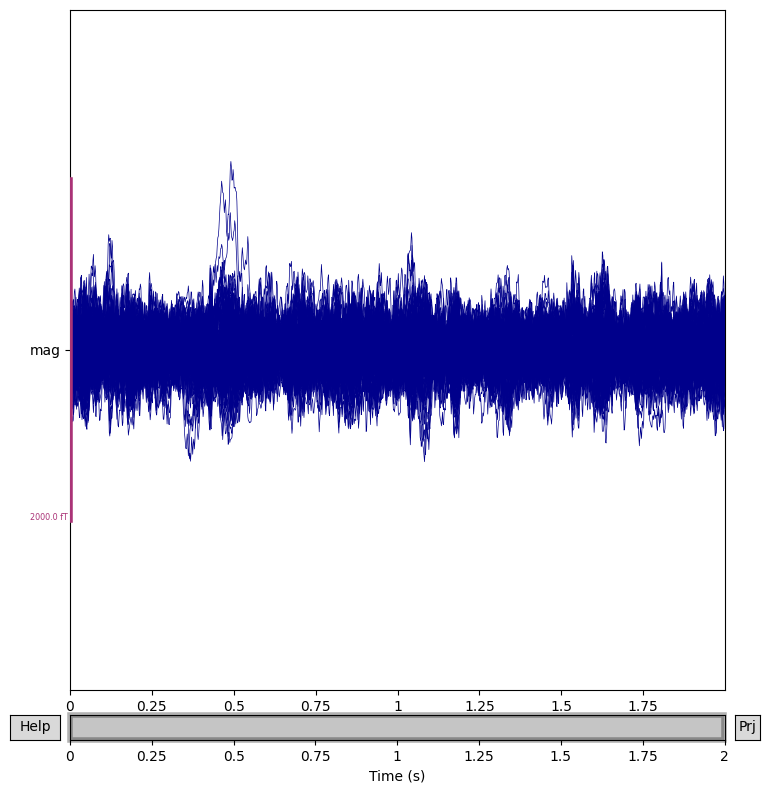

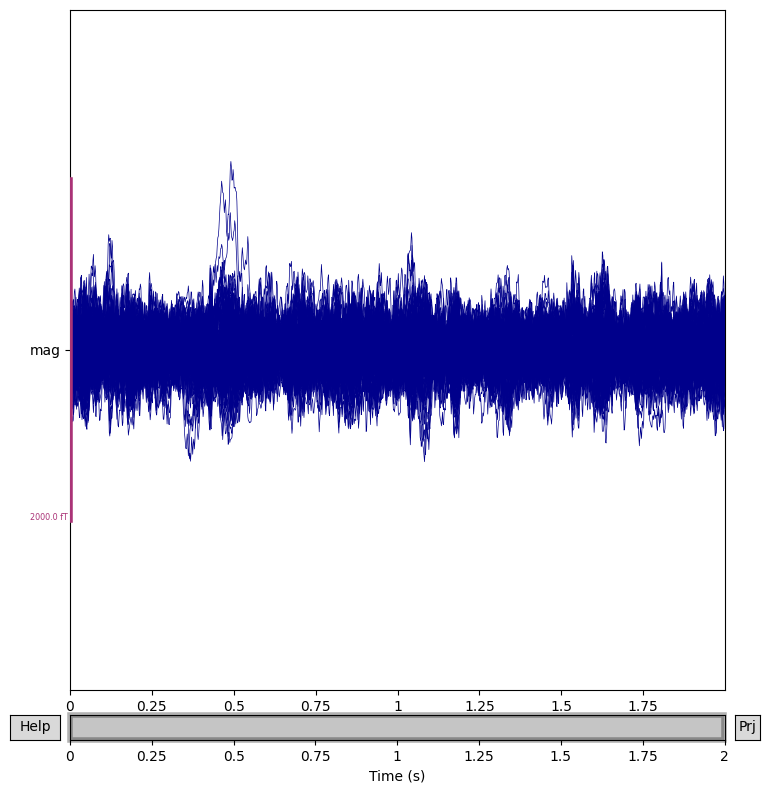

In [38]:
mags_ecg = raw.copy().crop(tmax=2).pick(picks="mag")
for data, title in zip([mags, mags_ecg], ["Without", "With"]):
    with mne.viz.use_browser_backend("matplotlib"):
        fig = data.plot(butterfly=True, proj=True)
    fig.subplots_adjust(top=0.9)
    fig.suptitle("{} ECG projector".format(title), size="xx-large", weight="bold")

### When are projectors "applied"?

By default, projectors are applied when creating :class:`epoched
<mne.Epochs>` data from :class:`~mne.io.Raw` data, though application of the
projectors can be *delayed* by passing ``proj=False`` to the
:class:`~mne.Epochs` constructor. However, even when projectors have not been
applied, the :meth:`mne.Epochs.get_data` method will return data *as if the
projectors had been applied* (though the :class:`~mne.Epochs` object will be
unchanged). Additionally, projectors cannot be applied if the data are not
`preloaded <memory>`. If the data are `memory-mapped`_ (i.e., not
preloaded), you can check the ``_projector`` attribute to see whether any
projectors will be applied once the data is loaded in memory.

Finally, when performing inverse imaging (i.e., with
:func:`mne.minimum_norm.apply_inverse`), the projectors will be
automatically applied. It is also possible to apply projectors manually when
working with :class:`~mne.io.Raw`, :class:`~mne.Epochs` or
:class:`~mne.Evoked` objects via the object's :meth:`~mne.io.Raw.apply_proj`
method. For all instance types, you can always copy the contents of
:samp:`{<instance>}.info['projs']` into a separate :class:`list` variable,
use :samp:`{<instance>}.del_proj({<index of proj(s) to remove>})` to remove
one or more projectors, and then add them back later with
:samp:`{<instance>}.add_proj({<list containing projs>})` if desired.

<div class="alert alert-danger"><h4>Warning</h4><p>Remember that once a projector is applied, it can't be un-applied, so
    during interactive / exploratory analysis it's a good idea to use the
    object's :meth:`~mne.io.Raw.copy` method before applying projectors.</p></div>


### Best practices

In general, it is recommended to apply projectors when creating
:class:`~mne.Epochs` from :class:`~mne.io.Raw` data. There are two reasons
for this recommendation:

1. It is computationally cheaper to apply projectors to data *after* the
   data have been reducted to just the segments of interest (the epochs)

2. If you are applying amplitude-based rejection criteria to epochs, it is
   preferable to reject based on the signal *after* projectors have been
   applied, because the projectors may reduce noise in some epochs to
   tolerable levels (thereby increasing the number of acceptable epochs and
   consequenty increasing statistical power in any later analyses).


## References

.. footbibliography::


.. LINKS

   https://docs.python.org/3/tutorial/controlflow.html#tut-unpacking-arguments

